## AML-3204 Social Media Analytics 

## Project Title: Collaborative Filtering-based vs Hybrid Recommender System

## Solution: Collaborative Filtering-Based Recommender using Matrix Factorization

### Group Members

- SAI VARUN KOLLIPARA - C0828403
- PRAMOD REDDY GURRALA – C0850493
- DEEKSHA NAIKAP – C0835440
- BHANU PRAKASH MAHADEVUNI – C0850515

## 1. Importing Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
import matplotlib.pyplot as plt
import random

from sklearn.metrics import mean_squared_error
#from surprise import accuracy

from numpy import count_nonzero
import progressbar as pb
import math

## 2. Importing the Data

In [2]:
#Loading movielens data
#Ratings
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data_files/u.data', sep='\t', names=rating_cols)

#Movies
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', "unknown", "Action", "Adventure", "Animation", "Children's",
"Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir","Horror", "Musical", " Mystery", "Romance", "Sci-Fi", "Thriller",
"War","Western"]
movies = pd.read_csv('data_files/u.item', sep='|', names=movie_cols, encoding='latin-1')

In [3]:
ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Data Pre-Processing

In [4]:
genre = []
for index, row in movies.iterrows():
    tmp = []
    n = 0
    for d in row:
        if d == 1:
            tmp.append(movie_cols[n])
        n=n+1
    if 'movie_id' in tmp:
        tmp.remove('movie_id')
    genre.append('|'.join(tmp))

## 3.1 Data Cleaning

In [5]:
movies.insert(loc=5, column='genres', value=genre)
movies.drop(["video_release_date","unknown", "Action", "Adventure", "Animation", "Children's",
"Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir","Horror", "Musical", " Mystery", "Romance", "Sci-Fi", "Thriller",
"War","Western"], axis='columns', inplace=True)

In [6]:
movies

,movie_id,title,release_date,imdb_url,genres
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action|Adventure|Thriller
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action|Comedy|Drama
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime|Drama|Thriller
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy


In [7]:
#Merging movie data with their ratings
movie_ratings = pd.merge(movies, ratings)

In [8]:
movie_ratings

,movie_id,title,release_date,imdb_url,genres,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,66,3,883601324
...,...,...,...,...,...,...,...,...
99995,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama,863,1,889289570
99996,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller,863,3,889289491
99997,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance,863,2,889289570
99998,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy,896,3,887160722


In [9]:
movie_ratings.to_csv('data_files/sorted_movie_data.csv')

## 3.2 Data Visualization

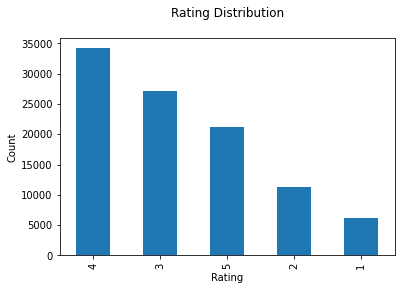

In [10]:
plt.rc("font", size=10)
movie_ratings.rating.value_counts(sort=True).plot(kind='bar')
plt.title("Rating Distribution\n")
plt.xlabel('Rating')
plt.ylabel('Count')
# plt.savefig('system1.png', bbox_inches='')
plt.show()

## 3.3 Pivot Table - Users VS Rating

In [11]:
#Pivot Table(This creates a matrix of users and movie_ratings)
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )

In [12]:
ratings_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.4 Data Splitting for Matrix Factorizing

In [13]:
# Split Data
def split_data(data, test_ratio):
    train_data, test_data = train_test_split(data, test_size = test_ratio, random_state=25)
    return train_data, test_data

n_users = movie_ratings.user_id.unique().shape[0]
n_items = movie_ratings.movie_id.unique().shape[0]

train, test = split_data(ratings_matrix, 0.2)

print(ratings_matrix.shape)
print(train.shape)
print(test.shape)

(1682, 943)
(1345, 943)
(337, 943)


## 4. Collaborative Filtering

In [14]:
non_zero = np.count_nonzero(train)
total_val = np.product(train.shape)

print('Non-Zeros: ',non_zero)
print('Total values',total_val)

Non-Zeros:  80233
Total values 1268335


In [15]:
#Calculate sparsity
sparsity = (total_val - non_zero) / total_val

#Calculate Density
density = non_zero / total_val

#sparsity = 1.0 -(count_nonzero(x) /float(x.size))
print('Sparsity:',sparsity.round(3))
print('Density:',density.round(3))

Sparsity: 0.937
Density: 0.063


## 4.1 matrix_factorization Function

In [16]:
def matrix_factorization(R, P, Q, K, steps, alpha=0.0002, beta=0.02):
    Q = Q.T
    print(type(steps),steps)
    for step in range(steps):
        for i in range(len(R)): #Iterate Rows of R: i.e: 1683
            for j in range(len(R[i])): #Iterate Columns of R: i.e: 944
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K): # K represents column of P & Rows of Q
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k]) # Gradient descent formula.
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j]) # Gradient descent formula.
        
        #Estimate for how well the prediction matrix is doing
        eR = np.dot(P,Q)
        e = 0
        counter = 0
        for i in range(len(R)): #Iterate Rows of R: i.e: 1683
            for j in range(len(R[i])): #Iterate Columns of R: i.e: 944
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    counter+=1
                    for k in range(K):  # K represents column of P & Rows of Q
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
                        counter+=1

        e=e/counter # Here, e is MSE
        rmse = math.sqrt(e)

        print(' STEP ===>',step,'; MSE:',round(e,5), '; RMSE:',round(rmse,5))
        if e < 0.01:
            break
    return P, Q.T


In [17]:
R = np.array(ratings_matrix)
N = len(R) # Rows
M = len(R[0]) # Columns
K = 50 # Random
P = np.random.rand(N,K)#6, size=(N,K))
Q = np.random.rand(M,K)#6, size=(M,K))
print(N, M)
print('P:',P.shape)
print('Q:',Q.shape)

1682 943
P: (1682, 50)
Q: (943, 50)


In [18]:
nP, nQ = matrix_factorization(R, P, Q, K, 20)
nR = np.dot(nP, nQ.T)

<class 'int'> 20
 STEP ===> 0 ; MSE: 0.23125 ; RMSE: 0.48089
 STEP ===> 1 ; MSE: 0.1252 ; RMSE: 0.35383
 STEP ===> 2 ; MSE: 0.09184 ; RMSE: 0.30305
 STEP ===> 3 ; MSE: 0.07585 ; RMSE: 0.2754
 STEP ===> 4 ; MSE: 0.0663 ; RMSE: 0.25748
 STEP ===> 5 ; MSE: 0.0598 ; RMSE: 0.24455
 STEP ===> 6 ; MSE: 0.05501 ; RMSE: 0.23453
 STEP ===> 7 ; MSE: 0.05126 ; RMSE: 0.22641
 STEP ===> 8 ; MSE: 0.04822 ; RMSE: 0.2196
 STEP ===> 9 ; MSE: 0.04569 ; RMSE: 0.21375
 STEP ===> 10 ; MSE: 0.04353 ; RMSE: 0.20863
 STEP ===> 11 ; MSE: 0.04165 ; RMSE: 0.20409
 STEP ===> 12 ; MSE: 0.04001 ; RMSE: 0.20002
 STEP ===> 13 ; MSE: 0.03855 ; RMSE: 0.19633
 STEP ===> 14 ; MSE: 0.03724 ; RMSE: 0.19297
 STEP ===> 15 ; MSE: 0.03606 ; RMSE: 0.18989
 STEP ===> 16 ; MSE: 0.03498 ; RMSE: 0.18704
 STEP ===> 17 ; MSE: 0.03401 ; RMSE: 0.1844
 STEP ===> 18 ; MSE: 0.03311 ; RMSE: 0.18195
 STEP ===> 19 ; MSE: 0.03228 ; RMSE: 0.17966


In [19]:
nR

array([[ 3.44817216,  3.88259465,  2.51823696, ...,  6.05746139,
         4.57483944,  3.44430216],
       [ 3.61922887,  4.4062312 ,  2.93195657, ...,  5.36970494,
         3.82642767,  3.21419987],
       [ 2.66256295,  3.71544112,  3.32780235, ...,  4.27406698,
         3.56208979,  3.04827062],
       ...,
       [ 5.92239283,  8.25398156,  7.40650237, ..., 11.0261655 ,
         8.11423752,  5.79366947],
       [ 5.00135244,  5.96490287,  5.67632894, ...,  9.98942063,
         6.97835814,  6.20943658],
       [ 4.61547287,  5.25451049,  5.33309492, ...,  7.00622003,
         5.22634126,  4.147195  ]])

In [20]:
pd.DataFrame(nR).to_csv('data_files/Collaborative_predictions.csv')

## 5. Recomendations using Cosine Similarity

In [21]:
#Cosine Similarity(Creates a cosine matrix of similaraties ..... which is the pairwise distances between two items )

movie_similarity = 1 - pairwise_distances( ratings_matrix.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_cosine = pd.DataFrame( movie_similarity )

In [22]:
ratings_matrix_cosine

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.000000,0.000000
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.000000,0.000000
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000
1680,0.047183,0.078299,0.000000,0.056413,0.000000,0.000000,0.051498,0.082033,0.057360,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [23]:
movie_ids = ratings_matrix_cosine.index
movie_list = list(movie_ids)
type(movie_list)

list

## 5.1 Function to Recommend based on the Similarity

In [24]:
# Function to select a random movie from the List of movies available

def get_movie_title():
    movie_id = random.choice(movie_list)
    movie_title = movie_ratings.title[movie_id]
    return movie_title

In [25]:
#Recommender
flag = True
try:
    user_input = get_movie_title()
    inp=movies[movies['title']==user_input].index.tolist()
    inp=inp[0]
    
    movies['similarity'] = ratings_matrix.iloc[inp]
    movies.columns = ['movie_id', 'title', 'release_date', 'imdb_url', 'genres','similarity']
    movies.head(5)
    
except Exception as e:
    flag = False
    if str(e) == 'list index out of range':
        print("Sorry, the movie is not in the database!")
    else:
        print(e)
        print("__________________________________________________________________________________")
        
if flag:
    print("Recommended movies based on your choice of ",user_input ,":")
    predicted = movies.sort_values( ["similarity"], ascending = False)

Recommended movies based on your choice of  Twelve Monkeys (1995) :


In [26]:
# Recommended List of movies based top to down based on similarity

predicted

,movie_id,title,release_date,imdb_url,genres,similarity
472,473,James and the Giant Peach (1996),12-Apr-1996,http://us.imdb.com/M/title-exact?James%20and%2...,Animation|Children's|Musical,5.0
535,536,Ponette (1996),23-May-1997,http://us.imdb.com/M/title-exact?Ponette%20%28...,Drama,5.0
561,562,"Quick and the Dead, The (1995)",01-Jan-1995,http://us.imdb.com/M/title-exact?Quick%20and%2...,Action|Adventure|Western,5.0
118,119,Maya Lin: A Strong Clear Vision (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Maya%20Lin:%2...,Documentary,5.0
119,120,Striptease (1996),28-Jun-1996,http://us.imdb.com/M/title-exact?Striptease%20...,Comedy|Crime,5.0
...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama,NaN
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller,NaN
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance,NaN
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy,NaN


In [27]:
ratings_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
